__File: toy_potential_phase_shifts.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 17, 2020__

This notebook looks at the effective range expansion functions of various potentials evaluating the phase shifts at the eigen-energies.

In [1]:
from os import chdir, getcwd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import RectBivariateSpline

In [2]:
# Working directory
cwd = getcwd()

# Constants and parameters
hbar_sq_over_m = 41.47 # MeV fm^2
theta_array = np.array( [-1.0, 0.01, 0.1, 1, 5] )

__Details of toy NN potential__:

Toy potential for proton-neutron scattering for the $^1$S$_0$ partial wave. Fit to experimental phase shifts and is given in coordinate space by $V(r)=V_a e^{-a x} / x + V_b e^{-b x} / x + V_c e^{-c x} / x$, where $x = \mu r$, $\mu = 0.7$ fm$^{−1}$ (the inverse of the pion mass), $V_a = −10.463$ MeV and $a=1$, $V_b =−1650.6$ MeV and $b=4$ and $V_c = 6484.3$ MeV and $c=7$. In momentum space, $V_{\eta} e^{-\eta x} / x \rightarrow V_{\eta} / (4 \mu k k')$ log$[( (\mu \eta)^2 + (k+k')^2 ) / ( (\mu \eta)^2 + (k-k')^2 ) ]$. We skip to this step in what follows.

In [3]:
def V_func(k, kp):
    
    # Make sure V_\eta constants are in units fm^-2

    # Constants
    mu = 0.7 # fm^-1

    # Parameters
    a = 1
    V_a = -10.463 / hbar_sq_over_m
    b = 4
    V_b = -1650.6 / hbar_sq_over_m
    c = 7
    V_c = 6484.3 / hbar_sq_over_m

    # Construct momentum-space potential in units fm
    return ( V_a * np.log( ( (mu*a)**2 + (k+kp)**2 ) / ( (mu*a)**2 + (k-kp)**2 ) ) + \
             V_b * np.log( ( (mu*b)**2 + (k+kp)**2 ) / ( (mu*b)**2 + (k-kp)**2 ) ) + \
             V_c * np.log( ( (mu*c)**2 + (k+kp)**2 ) / ( (mu*c)**2 + (k-kp)**2 ) ) ) / (4 * mu * k * kp)

In [4]:
def construct_momentum_mesh(k_max, k_mid, ntot, nmod):
    
    # Minimum momentum value
    k_min = 0.0

    x_array_1, x_weights_1 = leggauss(nmod) # Interval [-1,1]
    x_array_2, x_weights_2 = leggauss(ntot-nmod)
    
    # Convert from interval [-1, 1] to [a, b] (meaning x_array -> k_array)
    k_array_1 = 0.5 * (x_array_1 + 1) * (k_mid - k_min) + k_min
    k_weights_1 = (k_mid - k_min) / 2 * x_weights_1
    
    k_array_2 = 0.5 * (x_array_2 + 1) * (k_max - k_mid) + k_mid
    k_weights_2 = (k_max - k_mid) / 2 * x_weights_2
    
    k_array = np.concatenate( (k_array_1, k_array_2) )
    k_weights = np.concatenate( (k_weights_1, k_weights_2) )
    
    return k_array, k_weights

In [5]:
def construct_coarse_momentum_mesh(k_max, ntot):
    
    # Minimum momentum value
    k_min = 0.0

    x_array, x_weights = leggauss(ntot) # Interval [-1,1]
    
    # Convert from interval [-1, 1] to [a, b] (meaning x_array -> k_array)
    k_array = 0.5 * (x_array + 1) * (k_max - k_min) + k_min
    k_weights = (k_max - k_min) / 2 * x_weights

    return k_array, k_weights

In [6]:
def phase_shifts(e_array, V_matrix, k_array, k_weights):
    """
    Calculates NN phase shifts as a function of lab energy for a given 
    potential. Note, this function will not work for a coupled-channel
    potential.
    
    Parameters
    ----------
    e_array : 1-D ndarray
        Array of lab energies [MeV].
    V_matrix : 2-D ndarray
        Potential matrix [fm].
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    k_weights : 1-D ndarray
        Momentum weights [fm^-1].
    
    Returns
    -------
    phase_shifts : 1-D ndarray
        Array of phase shifts [deg] for each lab energy in e_array.
    
    """
    
    # Set-up

    # Length of the energy array
    M = len(e_array)
    
    # Maximum momentum value in fm^-1
    k_max = max(k_array)
        
    # Length of the momentum array
    N = len(k_array)
        
    # Interpolate potential with RectBivariateSpline
    V_func = RectBivariateSpline(k_array, k_array, V_matrix)
    
    # Initialize array for phase shifts
    phase_shifts = np.zeros(M)

    # Loop over each lab energy
    for i in range(M):
        
        # Lab energy
        e = e_array[i]
        
        # Momentum corresponding to center of mass energy E_lab / 2 where the 
        # factor of 41.47 converts from MeV to fm^-1
        k0 = np.sqrt( e / 2.0 / hbar_sq_over_m )
        
        # Build D_vector
        
        # First N elements of D_vector
        D_vector = 2.0/np.pi * ( k_weights * k_array**2 ) / \
                   ( k_array**2 - k0**2 )
        # N+1 element of D_vector
        D_last = -2.0/np.pi * k0**2 * ( np.sum( k_weights /
                 ( k_array**2 - k0**2 ) ) + np.log( ( k_max + k0 ) / \
                 ( k_max - k0 ) ) / ( 2.0*k0 ) )
        # Append N+1 element to D_vector
        D_vector = np.append(D_vector, D_last) # Length is now N+1
        
        # Append k0 to k_array
        k_full = np.append(k_array, k0)
        
        # Create meshes for interpolation
        col, row = np.meshgrid(k_full, k_full)
        
        # Append k0 points by using the interpolated potential
        V_matrix = V_func.ev(row, col)
            
        # Build F matrix, N+1 x N+1, unitless where F_ij = delta_ij + D_j V_ij
        F_matrix = np.identity(N+1) + np.tile( D_vector, (N+1, 1) ) * V_matrix

        # Calculate R matrix and define extremes of R_matrix
        R_matrix = la.solve(F_matrix, V_matrix) # Units fm

        phase_shifts[i] = np.arctan( -k0 * R_matrix[N, N] )

    # Return phase shifts in degrees
    return np.degrees(phase_shifts)

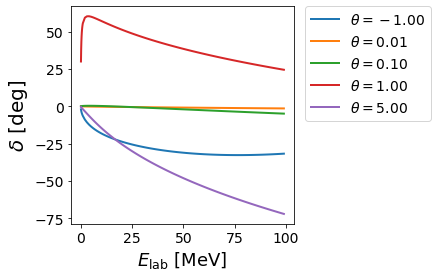

In [7]:
# --- Plot phase shifts for the three models with fine mesh --- #


# Construct standard Gauss-Legendre quadrature momentum mesh (units are fm^-1)
kmax = 30.0
kmid = 4.0
ntot = 120
nmod = 54
k_array, k_weights = construct_momentum_mesh(kmax, kmid, ntot, nmod)
krow, kcol = np.meshgrid(k_array, k_array)

# Lab energy
e_array = np.concatenate( (np.arange(0.1, 1.0, 0.1), np.arange(1.0, 100.0, 1.0)) )

# Figure size
width = 4
height = 4
figure_size = (width, height)

# Axes labels and fontsize
x_label = r'$E_{\rm lab}$' + ' [MeV]'
x_label_size = 18
y_label = r'$\delta$' + ' [deg]'
y_label_size = 20
axes_tick_size = 14

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size) 

# Curve width
curve_width = 2.0

# Loop over \theta values
for i, theta in enumerate(theta_array):
    
    # Evaluate matrix on fine mesh
    V_matrix = V_func(krow, kcol) * theta
    
    # Calculate phase shifts on fine mesh
    delta_array = phase_shifts(e_array, V_matrix, k_array, k_weights)
    
    # Curve color, styles, and labels
    curve_label = r'$\theta=%.2f$' % theta
    
    # Add curve to figure
    ax.plot(e_array, delta_array, label=curve_label, linewidth=curve_width)
    
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)
    
# Enlarge axes tick marks
ax.tick_params(labelsize=axes_tick_size)

# Add legend for channel
legend_size = 14
legend_location = 'upper left'
ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# Save figure
file_name = 'phase_shifts_toy_potentials_%d_knodes_kmax%d.pdf' % (ntot, kmax)
chdir('Figures/Unitarity_function')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)

__Calculate $L=0$ effective range expansion functions for the various models at eigen-energies__

/Users/anthonytropiano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in sqrt
/Users/anthonytropiano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log
/Users/anthonytropiano/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in sqrt


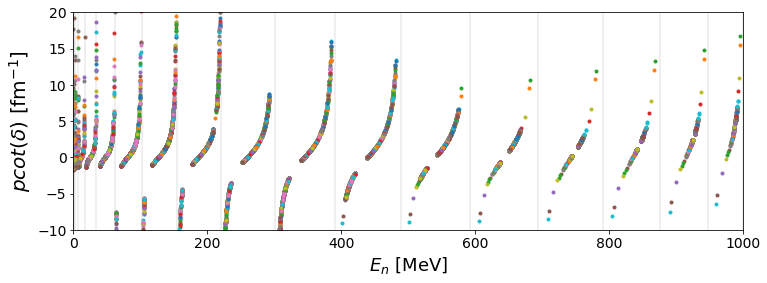

In [11]:
# --- Calculate p*cot(\delta(E_i)) at eigen-energies E_i --- #


# Now do phase shifts for many \theta values in between -5 to 5
theta_array = np.array( ( np.random.rand(1000) - 0.5 ) ) * 10

# Maximum momentum value
k_max_small = 5.0
# Number of nodes
ntot_small = 20
# New smaller mesh
k_array_small, k_weights_small = construct_coarse_momentum_mesh(k_max_small, ntot_small)
krow_small, kcol_small = np.meshgrid(k_array_small, k_array_small)

# Relative kinetic energy in units MeV on small mesh
T_matrix_MeV = hbar_sq_over_m * np.diag( k_array_small**2 )

# Convert potential to MeV with these grids
factor_array = np.sqrt( (2*k_weights_small)/np.pi ) * k_array_small # fm^-3/2
frow, fcol = np.meshgrid(factor_array, factor_array)

# Figure size
# width = 4
width = 12
height = 4
figure_size = (width, height)
    
# Axes limits
# xlim = [0.0, 250.0]
xlim = (0, 1000)
ylim = (-10, 20)
        
# Axes labels and fontsize
x_label = r'$E_n$' + ' [MeV]'
x_label_size = 18
y_label = r'$p cot(\delta)$' + ' [fm' + r'$^{-1}$' + ']'
y_label_size = 20
axes_tick_size = 14

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size) 

# Loop over \theta values
for i, theta in enumerate(theta_array):
    
    V_matrix_small = V_func(krow_small, kcol_small) * theta
    V_matrix_MeV_small = V_matrix_small * frow * fcol * hbar_sq_over_m # fm * fm-3 * MeV fm^2 = MeV

    # Calculate Hamiltonian
    H_matrix_MeV = T_matrix_MeV + V_matrix_MeV_small

    # Get eigenvalues
    eigenvalues, _ = la.eigh(H_matrix_MeV)

#     # Remove negative eigenvalues?
#     for eig in eigenvalues:
#         if eig < 0.0:
#             # Find the index of the eigenvalue
#             e_difference_array = np.fabs(eigenvalues - eig)
#             eig_index = e_difference_array.argmin()
#             eigenvalues = np.delete(eigenvalues, eig_index)
    
#     # Now put V on a fine mesh
#     V_matrix_full = V_func(krow, kcol) * theta
    
    # Calculate phase shifts (eigenvalues must be entered in as lab frame)
#     delta_array = np.radians( phase_shifts(2*eigenvalues, V_matrix_full, k_array, k_weights) )
    delta_array = np.radians( phase_shifts(2*eigenvalues, V_matrix_small, k_array_small, k_weights_small) )
    
    # Calculate p*cot(\delta)
    p_array = np.sqrt( eigenvalues / hbar_sq_over_m ) # fm^-1
    pcot_array = p_array / np.tan(delta_array)
    
#     # Curve color, styles, and labels
#     curve_label = r'$\theta=%.2f$' % theta
    
    # Add curve to figure
    ax.scatter(eigenvalues, pcot_array, marker='.')
    
# Add free energies as horizontal lines (cot(0)=\infty)
free_energies, _ = la.eigh(T_matrix_MeV)
for eps in free_energies:
    ax.axvline(x=eps, color='xkcd:gray', alpha=0.2)
    
# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
    
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)
    
# Enlarge axes tick marks
ax.tick_params(labelsize=axes_tick_size)

# # Add legend for channel
# legend_size = 16
# legend_location = 'upper right'
# ax.legend(loc=legend_location, fontsize=legend_size)

# Save figure
file_name = 'ere_toy_potentials_%d_knodes_kmax%d.pdf' % (ntot_small, k_max_small)
chdir('Figures/Unitarity_function')
f.savefig(file_name, bbox_inches='tight')
chdir(cwd)